In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from lib.acoustic_model import AcousticModel
import lib.dataset as dataset
from lib.opt import optimize
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

checkpoint_dir = '_linear16384'
window = 16384

In [3]:
train_set = dataset.OrcaDataset(root='data', train=True, window=window)
test_set = dataset.OrcaDataset(root='data', train=False, window=window)

Loaded dataset with 129199 datapoints
Loaded dataset with 25853 datapoints


In [4]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def define_graph(self, debug=False):
        self.m = 1
        self.k = 500
        self.d = 1024
        self.stride = 512
        self.regions = 1 + int(window - self.d)//self.stride
        self.epsilon = 10e-8 # fudge factor for normalization
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
        self.beta = nn.Parameter(torch.Tensor(self.regions*self.k,self.m))
        self.bias = nn.Parameter(torch.Tensor(self.m))
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return torch.mm(zx.view(x.data.size()[0],self.regions*self.k), self.beta) + self.bias

In [5]:
model = Model(checkpoint_dir, avg=.9, weight_scale=0)
model.initialize()

beta torch.Size([15500, 1]) (15500)
bias torch.Size([1]) (1)
Initialized graph with 15501 parameters


In [6]:
optimize(model,train_set,test_set,learning_rate=0.0000001,batch_size=256,workers=4)

Initiating optimizer, 505 iterations/epoch.
avp_tr	avp_ts	iter	loss_tr	loss_ts	time	utime
34.94   14.68   0       0.175   0.073   15.37   14.94   
31.51   14.53   505     0.159   0.066   27.57   15.17   
41.31   25.61   1010    0.151   0.065   27.62   14.97   
42.56   33.77   1515    0.145   0.064   34.41   20.33   
43.21   38.21   2020    0.140   0.063   39.49   21.57   
43.60   40.24   2525    0.136   0.062   48.82   26.32   
43.88   41.25   3030    0.133   0.061   50.14   26.39   
44.10   41.83   3535    0.130   0.060   49.96   26.26   
44.28   42.19   4040    0.128   0.060   49.65   26.24   
44.45   42.43   4545    0.126   0.059   50.82   27.22   
44.59   42.60   5050    0.125   0.059   49.72   26.46   
44.73   42.72   5555    0.124   0.059   50.42   26.64   
44.86   42.80   6060    0.123   0.058   50.90   27.16   
44.99   42.85   6565    0.122   0.058   50.47   26.68   
45.11   42.88   7070    0.122   0.058   49.41   26.65   
45.22   42.89   7575    0.121   0.058   50.82   27.44  

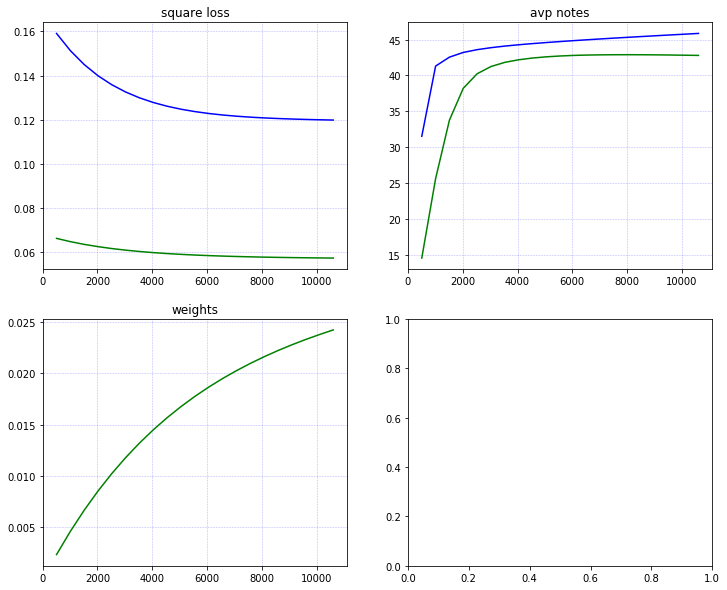

In [7]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('square loss',model.stats['loss_tr'][2],color='b')
plt.plot('square loss',model.stats['loss_ts'][2],color='g',share=True)
plt.plot('avp notes',model.stats['avp_tr'][2],color='b')
plt.plot('avp notes',model.stats['avp_ts'][2],color='g',share=True)
plt.plot('weights',model.sum_weights('beta'),color='g')
plt.show()

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=256,drop_last=False,**dataset.worker_config)
yhat,y = model.predict_all(test_loader)

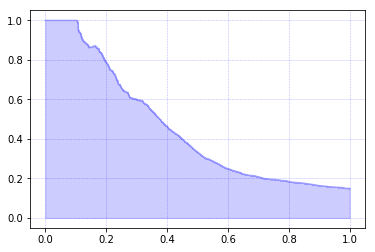

In [9]:
media.plot_pr_curve(y,yhat)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y.ravel(),yhat.ravel()>.04,average='binary')
print(p,r,f)

0.41597796143250687 0.4377965208223511 0.4266084499807371
